# Imports

In [1]:
from google.cloud import bigquery
import pandas as pd
from pandas_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import math

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

# Reading Queries

In [7]:
total_signups_query = open('Queries/total_signups_query.sql', 'r').read()
signup_completed_query = open('Queries/signup_completed_query.sql', 'r').read()
devs_vetted_query = open('Queries/devs_vetted_query.sql', 'r').read()
devs_shortlisted_query = open('Queries/devs_shortlisted_query.sql', 'r').read()
devs_chosen_query = open('Queries/devs_chosen_query.sql', 'r').read()

# Useful Functions

In [8]:
def query_result(query):
    client = bigquery.Client('turing-230020')
    output = client.query(query).to_dataframe()
    client.close()
    return output

def data_preprocess(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df[df['date'] >= '2019-09-01']

    date_range = pd.date_range(df['date'].min(), df['date'].max())

    df = df.set_index('date')
    df = df.reindex(date_range, fill_value=0)
    df = df.reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = df['ds'].dt.tz_localize(None)
    df['mean'] = df['y'].rolling(window=7).mean()
    
    return df

def train_test_split(data):
    timestamp = total_signups.loc[round (total_signups.shape[0] * 95/100)]['ds']
    
    train, test = total_signups[total_signups['ds'] < timestamp], total_signups[total_signups['ds'] >= timestamp]
    
    return train, test

def call_prophet(data):
    global_yearly_seasonality = True
    global_weekly_seasonality = True
    global_daily_seasonality = True
    global_holiday_effect = True
    global_seasonality_mode = 'additive'
    global_interval_width = 0.8
    global_performance_RMSE = float('inf')
    
    for yearly_seasonality in [False, True]:
        for weekly_seasonality in [False, True]:
            for daily_seasonality in [False, True]:
                for seasonality_mode in ['additive', 'multiplicative']:
                    for interval_width in [0.95, 0.99]:
                        for holiday_effect in [False, True]:
    
                            model = Prophet(daily_seasonality=daily_seasonality, yearly_seasonality=yearly_seasonality
                                            , weekly_seasonality=weekly_seasonality, seasonality_mode=seasonality_mode
                                            , interval_width=interval_width, changepoint_range=0.8)

                            if holiday_effect:
                                model.add_country_holidays(country_name='US')

                            model.fit(data)
                            forecast = model.predict(data)

                            performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

                            performance_MSE = mean_squared_error(performance['y'], performance['yhat'])
                            performance_RMSE = math.sqrt(performance_MSE)
                            
                            if performance_RMSE < global_performance_RMSE:
                                
                                print('New:')
                                print("Daily Seasonality:", daily_seasonality)
                                print("Weekly Seasonality:", weekly_seasonality)
                                print("Yearly Seasonality:", yearly_seasonality)
                                print("Holiday Effect:", holiday_effect)
                                print("Seasonality Mode:", seasonality_mode)
                                print("Interval Width:", interval_width)
                                
                                print(global_performance_RMSE, performance_RMSE)
                                
                                global_yearly_seasonality = yearly_seasonality
                                global_weekly_seasonality = weekly_seasonality
                                global_daily_seasonality = daily_seasonality
                                global_seasonality_mode = seasonality_mode
                                global_interval_width = interval_width
                                global_holiday_effect = holiday_effect
                                global_performance_RMSE = performance_RMSE

    print("Daily Seasonality:", global_daily_seasonality)
    print("Weekly Seasonality:", global_weekly_seasonality)
    print("Yearly Seasonality:", global_yearly_seasonality)
    print("Holiday Effect:", global_holiday_effect)
    print("Seasonality Mode:", global_seasonality_mode)
    print("Interval Width:", global_interval_width)
    model = Prophet(daily_seasonality=global_daily_seasonality, yearly_seasonality=global_yearly_seasonality
                    , weekly_seasonality=global_weekly_seasonality, seasonality_mode=global_seasonality_mode
                    , interval_width=global_interval_width, changepoint_range=0.8)
    
    if global_holiday_effect:
        model.add_country_holidays(country_name='US')

    model.fit(data)
    forecast = model.predict(data)
                
    performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
    performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)
    print(performance['anomaly'].value_counts())

    performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
    print(f'The MAE for the model is {performance_MAE}')

    performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
    print(f'The MAPE for the model is {performance_MAPE}')
    
    performance_MSE = mean_squared_error(performance['y'], performance['yhat'])
    performance_RMSE = math.sqrt(performance_MSE)
    print(f'The RMSE for the model is {performance_RMSE}')
    
    model.plot(forecast)
    model.plot_components(forecast)
                
    anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
    anomalies['day_name'] = (anomalies['ds'].dt.day_name()).values
    
    return anomalies

# Data

In [4]:
total_signups = query_result(total_signups_query)
total_signups = data_preprocess(total_signups)

signup_completed = query_result(signup_completed_query)
signup_completed = data_preprocess(signup_completed)

devs_vetted = query_result(devs_vetted_query)
devs_vetted = data_preprocess(devs_vetted)

devs_shortlisted = query_result(devs_shortlisted_query)
devs_shortlisted = data_preprocess(devs_shortlisted)

devs_chosen = query_result(devs_chosen_query)
devs_chosen = data_preprocess(devs_chosen)

# Prophet

08:22:32 - cmdstanpy - INFO - Chain [1] start processing
08:22:32 - cmdstanpy - INFO - Chain [1] done processing
08:22:34 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
inf 677.5516937096479


08:22:34 - cmdstanpy - INFO - Chain [1] done processing
08:22:42 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
677.5516937096479 671.8624131027115


08:22:43 - cmdstanpy - INFO - Chain [1] done processing
08:22:45 - cmdstanpy - INFO - Chain [1] start processing
08:22:45 - cmdstanpy - INFO - Chain [1] done processing
08:22:53 - cmdstanpy - INFO - Chain [1] start processing
08:22:53 - cmdstanpy - INFO - Chain [1] done processing
08:22:56 - cmdstanpy - INFO - Chain [1] start processing
08:22:56 - cmdstanpy - INFO - Chain [1] done processing
08:23:03 - cmdstanpy - INFO - Chain [1] start processing
08:23:04 - cmdstanpy - INFO - Chain [1] done processing
08:23:06 - cmdstanpy - INFO - Chain [1] start processing
08:23:06 - cmdstanpy - INFO - Chain [1] done processing
08:23:14 - cmdstanpy - INFO - Chain [1] start processing
08:23:14 - cmdstanpy - INFO - Chain [1] done processing
08:23:16 - cmdstanpy - INFO - Chain [1] start processing
08:23:17 - cmdstanpy - INFO - Chain [1] done processing
08:23:24 - cmdstanpy - INFO - Chain [1] start processing
08:23:24 - cmdstanpy - INFO - Chain [1] done processing
08:23:27 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: True
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
671.8624131027115 573.4878510084824


08:23:39 - cmdstanpy - INFO - Chain [1] done processing
08:23:47 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
573.4878510084824 568.3439207863823


08:23:48 - cmdstanpy - INFO - Chain [1] done processing
08:23:50 - cmdstanpy - INFO - Chain [1] start processing
08:23:51 - cmdstanpy - INFO - Chain [1] done processing
08:23:59 - cmdstanpy - INFO - Chain [1] start processing
08:23:59 - cmdstanpy - INFO - Chain [1] done processing
08:24:02 - cmdstanpy - INFO - Chain [1] start processing
08:24:02 - cmdstanpy - INFO - Chain [1] done processing
08:24:09 - cmdstanpy - INFO - Chain [1] start processing
08:24:10 - cmdstanpy - INFO - Chain [1] done processing
08:24:12 - cmdstanpy - INFO - Chain [1] start processing
08:24:12 - cmdstanpy - INFO - Chain [1] done processing
08:24:20 - cmdstanpy - INFO - Chain [1] start processing
08:24:20 - cmdstanpy - INFO - Chain [1] done processing
08:24:22 - cmdstanpy - INFO - Chain [1] start processing
08:24:23 - cmdstanpy - INFO - Chain [1] done processing
08:24:30 - cmdstanpy - INFO - Chain [1] start processing
08:24:30 - cmdstanpy - INFO - Chain [1] done processing
08:24:33 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
568.3439207863823 531.6304839844171


08:25:21 - cmdstanpy - INFO - Chain [1] done processing
08:25:29 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
531.6304839844171 527.5905150100427


08:25:29 - cmdstanpy - INFO - Chain [1] done processing
08:25:37 - cmdstanpy - INFO - Chain [1] start processing
08:25:38 - cmdstanpy - INFO - Chain [1] done processing
08:25:46 - cmdstanpy - INFO - Chain [1] start processing
08:25:46 - cmdstanpy - INFO - Chain [1] done processing
08:25:53 - cmdstanpy - INFO - Chain [1] start processing
08:25:54 - cmdstanpy - INFO - Chain [1] done processing
08:26:01 - cmdstanpy - INFO - Chain [1] start processing
08:26:01 - cmdstanpy - INFO - Chain [1] done processing
08:26:09 - cmdstanpy - INFO - Chain [1] start processing
08:26:10 - cmdstanpy - INFO - Chain [1] done processing
08:26:17 - cmdstanpy - INFO - Chain [1] start processing
08:26:17 - cmdstanpy - INFO - Chain [1] done processing
08:26:25 - cmdstanpy - INFO - Chain [1] start processing
08:26:25 - cmdstanpy - INFO - Chain [1] done processing
08:26:33 - cmdstanpy - INFO - Chain [1] start processing
08:26:33 - cmdstanpy - INFO - Chain [1] done processing
08:26:41 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: True
Weekly Seasonality: False
Yearly Seasonality: True
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
527.5905150100427 510.7066646929117


08:27:30 - cmdstanpy - INFO - Chain [1] done processing
08:27:38 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: False
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
510.7066646929117 508.23487922841827


08:27:39 - cmdstanpy - INFO - Chain [1] done processing
08:27:47 - cmdstanpy - INFO - Chain [1] start processing
08:27:48 - cmdstanpy - INFO - Chain [1] done processing
08:27:55 - cmdstanpy - INFO - Chain [1] start processing
08:27:56 - cmdstanpy - INFO - Chain [1] done processing
08:28:03 - cmdstanpy - INFO - Chain [1] start processing
08:28:03 - cmdstanpy - INFO - Chain [1] done processing
08:28:11 - cmdstanpy - INFO - Chain [1] start processing
08:28:11 - cmdstanpy - INFO - Chain [1] done processing
08:28:19 - cmdstanpy - INFO - Chain [1] start processing
08:28:19 - cmdstanpy - INFO - Chain [1] done processing
08:28:27 - cmdstanpy - INFO - Chain [1] start processing
08:28:27 - cmdstanpy - INFO - Chain [1] done processing
08:28:34 - cmdstanpy - INFO - Chain [1] start processing
08:28:35 - cmdstanpy - INFO - Chain [1] done processing
08:28:42 - cmdstanpy - INFO - Chain [1] start processing
08:28:43 - cmdstanpy - INFO - Chain [1] done processing
08:28:50 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
508.23487922841827 468.13392049506916


08:29:39 - cmdstanpy - INFO - Chain [1] done processing
08:29:47 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
468.13392049506916 465.44808400839355


08:29:49 - cmdstanpy - INFO - Chain [1] done processing
08:29:56 - cmdstanpy - INFO - Chain [1] start processing
08:29:57 - cmdstanpy - INFO - Chain [1] done processing
08:30:05 - cmdstanpy - INFO - Chain [1] start processing


Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95


08:30:06 - cmdstanpy - INFO - Chain [1] done processing


0    1027
1      67
Name: anomaly, dtype: int64
The MAE for the model is 289.42091275661056
The MAPE for the model is 0.4071532748371296
The RMSE for the model is 465.44808400839355
             ds     y         mean         yhat   yhat_lower   yhat_upper  \
217  2020-04-05  1066   345.000000   143.656557  -713.589438  1058.108764   
226  2020-04-14  1445   372.571429   176.830263  -733.844396  1118.881205   
246  2020-05-04  1393   449.857143   180.149113  -795.680823  1108.667801   
315  2020-07-12  1268   241.000000   106.197376  -762.577659   959.606510   
337  2020-08-03  1073   199.285714   171.305444  -658.365707  1062.111357   
359  2020-08-25  1602   280.000000   247.079888  -627.247298  1154.943482   
580  2021-04-03  3682  3174.857143  2364.659961  1464.752974  3268.593050   
581  2021-04-04  4402  3419.285714  2433.472874  1568.156815  3268.249311   
582  2021-04-05  4742  3691.714286  3008.017350  2091.909533  3922.044562   
583  2021-04-06  4700  3970.857143  3003.219739 

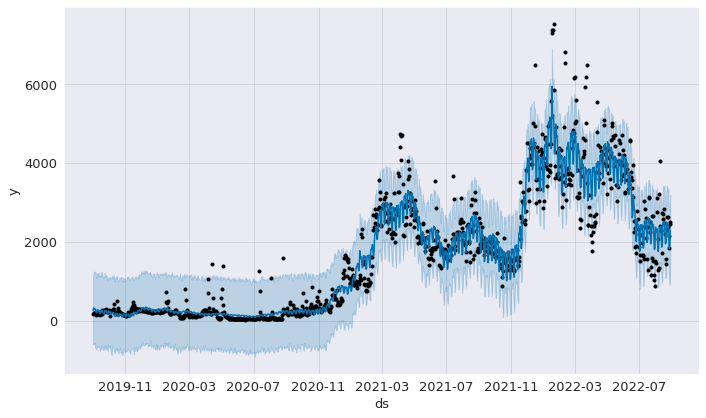

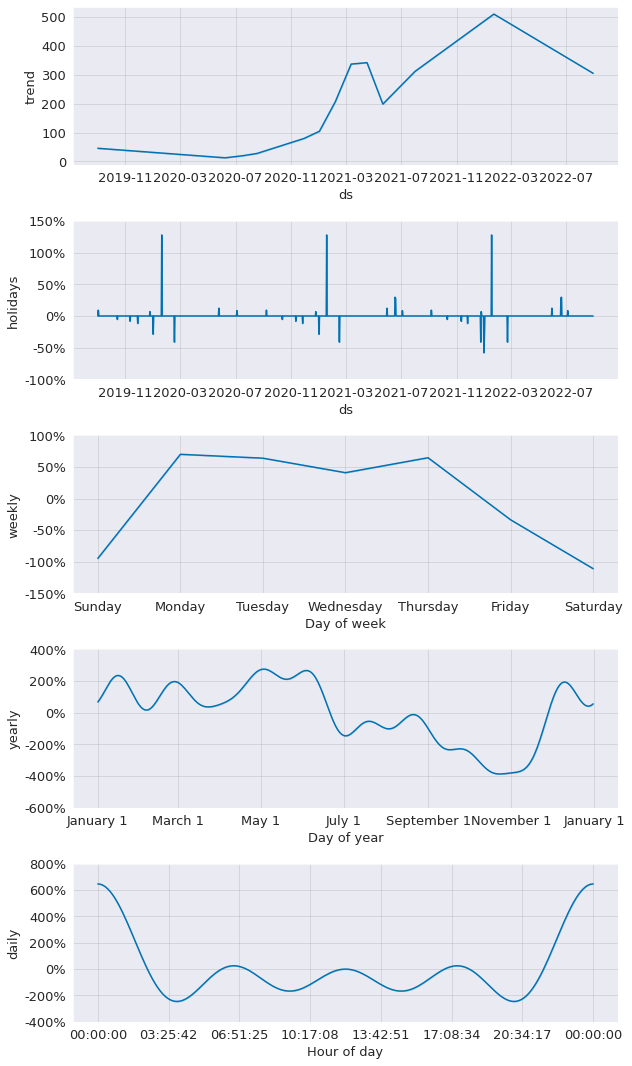

In [9]:
data = total_signups

anomalies = call_prophet(data)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(anomalies)

08:30:17 - cmdstanpy - INFO - Chain [1] start processing
08:30:17 - cmdstanpy - INFO - Chain [1] done processing
08:30:19 - cmdstanpy - INFO - Chain [1] start processing
08:30:19 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
inf 391.6236498459621


08:30:21 - cmdstanpy - INFO - Chain [1] start processing
08:30:21 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
391.6236498459621 381.58588979016747


08:30:23 - cmdstanpy - INFO - Chain [1] start processing
08:30:23 - cmdstanpy - INFO - Chain [1] done processing
08:30:25 - cmdstanpy - INFO - Chain [1] start processing
08:30:25 - cmdstanpy - INFO - Chain [1] done processing
08:30:28 - cmdstanpy - INFO - Chain [1] start processing
08:30:28 - cmdstanpy - INFO - Chain [1] done processing
08:30:30 - cmdstanpy - INFO - Chain [1] start processing
08:30:30 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
381.58588979016747 377.94973490386093


08:30:32 - cmdstanpy - INFO - Chain [1] start processing
08:30:32 - cmdstanpy - INFO - Chain [1] done processing
08:30:34 - cmdstanpy - INFO - Chain [1] start processing
08:30:34 - cmdstanpy - INFO - Chain [1] done processing
08:30:36 - cmdstanpy - INFO - Chain [1] start processing
08:30:36 - cmdstanpy - INFO - Chain [1] done processing
08:30:42 - cmdstanpy - INFO - Chain [1] start processing
08:30:42 - cmdstanpy - INFO - Chain [1] done processing
08:30:44 - cmdstanpy - INFO - Chain [1] start processing
08:30:45 - cmdstanpy - INFO - Chain [1] done processing
08:30:51 - cmdstanpy - INFO - Chain [1] start processing
08:30:51 - cmdstanpy - INFO - Chain [1] done processing
08:30:53 - cmdstanpy - INFO - Chain [1] start processing
08:30:53 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: True
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
377.94973490386093 354.36832207941285


08:31:00 - cmdstanpy - INFO - Chain [1] start processing
08:31:00 - cmdstanpy - INFO - Chain [1] done processing
08:31:02 - cmdstanpy - INFO - Chain [1] start processing
08:31:02 - cmdstanpy - INFO - Chain [1] done processing
08:31:08 - cmdstanpy - INFO - Chain [1] start processing
08:31:08 - cmdstanpy - INFO - Chain [1] done processing
08:31:10 - cmdstanpy - INFO - Chain [1] start processing
08:31:10 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
354.36832207941285 335.18464666415053


08:31:17 - cmdstanpy - INFO - Chain [1] start processing
08:31:17 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
335.18464666415053 325.7324508541527


08:31:19 - cmdstanpy - INFO - Chain [1] start processing
08:31:19 - cmdstanpy - INFO - Chain [1] done processing
08:31:25 - cmdstanpy - INFO - Chain [1] start processing
08:31:25 - cmdstanpy - INFO - Chain [1] done processing
08:31:27 - cmdstanpy - INFO - Chain [1] start processing
08:31:27 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
325.7324508541527 325.72340484102443


08:31:34 - cmdstanpy - INFO - Chain [1] start processing
08:31:34 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
325.72340484102443 316.71981055891183


08:31:36 - cmdstanpy - INFO - Chain [1] start processing
08:31:36 - cmdstanpy - INFO - Chain [1] done processing
08:31:42 - cmdstanpy - INFO - Chain [1] start processing
08:31:42 - cmdstanpy - INFO - Chain [1] done processing
08:31:44 - cmdstanpy - INFO - Chain [1] start processing
08:31:44 - cmdstanpy - INFO - Chain [1] done processing
08:31:51 - cmdstanpy - INFO - Chain [1] start processing
08:31:51 - cmdstanpy - INFO - Chain [1] done processing
08:31:53 - cmdstanpy - INFO - Chain [1] start processing
08:31:53 - cmdstanpy - INFO - Chain [1] done processing
08:32:00 - cmdstanpy - INFO - Chain [1] start processing
08:32:00 - cmdstanpy - INFO - Chain [1] done processing
08:32:02 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
316.71981055891183 288.42473333597474


08:32:02 - cmdstanpy - INFO - Chain [1] done processing
08:32:09 - cmdstanpy - INFO - Chain [1] start processing
08:32:09 - cmdstanpy - INFO - Chain [1] done processing
08:32:11 - cmdstanpy - INFO - Chain [1] start processing
08:32:11 - cmdstanpy - INFO - Chain [1] done processing
08:32:18 - cmdstanpy - INFO - Chain [1] start processing
08:32:18 - cmdstanpy - INFO - Chain [1] done processing
08:32:24 - cmdstanpy - INFO - Chain [1] start processing
08:32:24 - cmdstanpy - INFO - Chain [1] done processing
08:32:30 - cmdstanpy - INFO - Chain [1] start processing
08:32:30 - cmdstanpy - INFO - Chain [1] done processing
08:32:37 - cmdstanpy - INFO - Chain [1] start processing
08:32:37 - cmdstanpy - INFO - Chain [1] done processing
08:32:43 - cmdstanpy - INFO - Chain [1] start processing
08:32:43 - cmdstanpy - INFO - Chain [1] done processing
08:32:50 - cmdstanpy - INFO - Chain [1] start processing
08:32:50 - cmdstanpy - INFO - Chain [1] done processing
08:32:56 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
288.42473333597474 273.47701712036036


08:34:15 - cmdstanpy - INFO - Chain [1] start processing
08:34:15 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
273.47701712036036 268.03115227643156


08:34:21 - cmdstanpy - INFO - Chain [1] start processing
08:34:21 - cmdstanpy - INFO - Chain [1] done processing
08:34:28 - cmdstanpy - INFO - Chain [1] start processing
08:34:28 - cmdstanpy - INFO - Chain [1] done processing
08:34:34 - cmdstanpy - INFO - Chain [1] start processing
08:34:34 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
268.03115227643156 265.8605342437545


08:34:41 - cmdstanpy - INFO - Chain [1] start processing
08:34:41 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
265.8605342437545 259.7170788381031


08:34:47 - cmdstanpy - INFO - Chain [1] start processing
08:34:47 - cmdstanpy - INFO - Chain [1] done processing
08:34:54 - cmdstanpy - INFO - Chain [1] start processing
08:34:54 - cmdstanpy - INFO - Chain [1] done processing
08:35:00 - cmdstanpy - INFO - Chain [1] start processing
08:35:00 - cmdstanpy - INFO - Chain [1] done processing
08:35:07 - cmdstanpy - INFO - Chain [1] start processing
08:35:07 - cmdstanpy - INFO - Chain [1] done processing
08:35:13 - cmdstanpy - INFO - Chain [1] start processing
08:35:13 - cmdstanpy - INFO - Chain [1] done processing
08:35:20 - cmdstanpy - INFO - Chain [1] start processing
08:35:20 - cmdstanpy - INFO - Chain [1] done processing
08:35:26 - cmdstanpy - INFO - Chain [1] start processing
08:35:26 - cmdstanpy - INFO - Chain [1] done processing
08:35:33 - cmdstanpy - INFO - Chain [1] start processing
08:35:33 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
259.7170788381031 258.06992269482197


08:35:39 - cmdstanpy - INFO - Chain [1] start processing
08:35:39 - cmdstanpy - INFO - Chain [1] done processing
08:35:46 - cmdstanpy - INFO - Chain [1] start processing


Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95


08:35:46 - cmdstanpy - INFO - Chain [1] done processing


0    446
1     28
Name: anomaly, dtype: int64
The MAE for the model is 186.08620313909836
The MAPE for the model is 0.264569559927771
The RMSE for the model is 258.06992269482197
            ds     y         mean         yhat   yhat_lower   yhat_upper  \
28  2021-06-10  1923  1013.000000  1175.462014   674.797054  1665.509684   
29  2021-06-11  1587  1128.714286   961.542807   452.127900  1461.731663   
62  2021-07-14  1692  1081.142857   974.039771   475.815385  1505.959791   
88  2021-08-09   397   879.000000  1016.391684   507.140245  1523.536698   
89  2021-08-10    22   718.571429   922.862145   417.139420  1415.082857   
90  2021-08-11    55   586.000000   955.998558   426.334263  1463.478157   
217 2021-12-16  2907  1990.714286  1991.510577  1482.395522  2494.007255   
245 2022-01-13  1719  1695.714286  2213.106810  1726.451551  2706.193301   
250 2022-01-18  2912  2119.571429  2159.955455  1672.112438  2657.548705   
251 2022-01-19  3101  2317.000000  2199.327206  1704.273021  

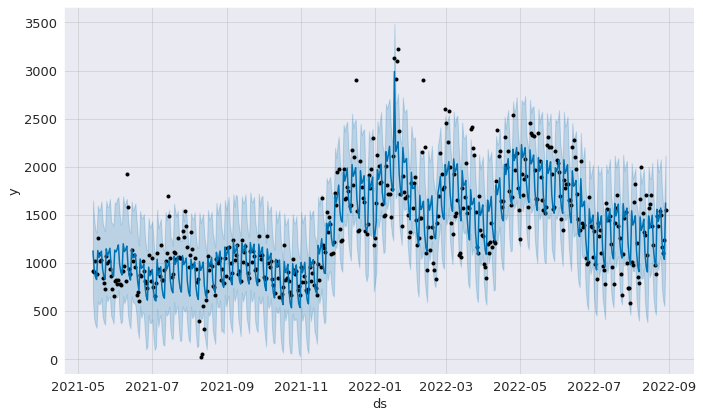

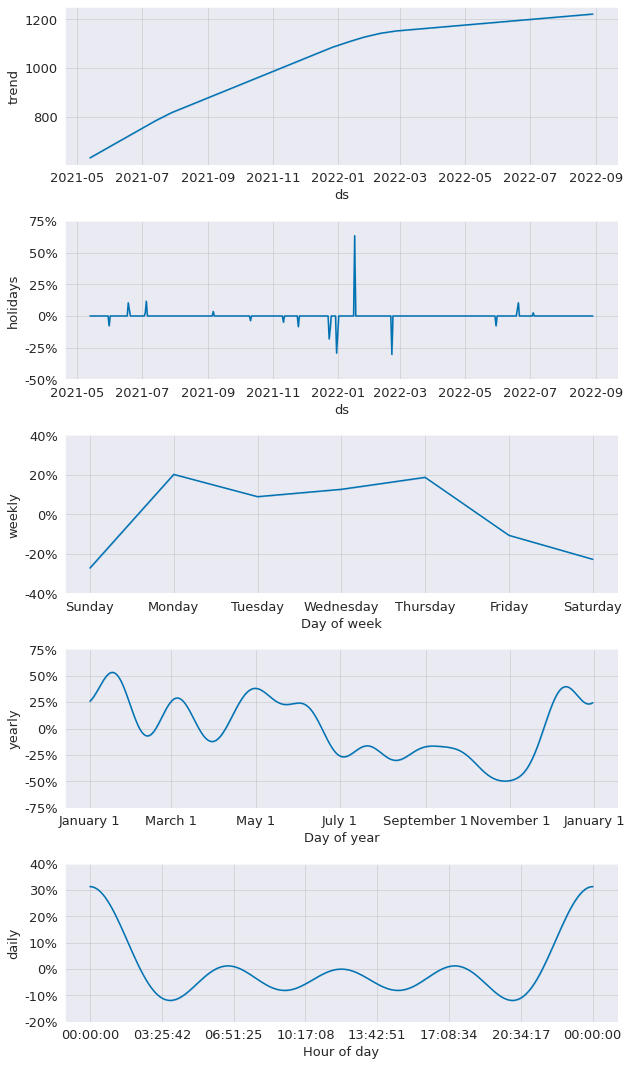

In [10]:
data = signup_completed

anomalies = call_prophet(data)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(anomalies)

08:35:56 - cmdstanpy - INFO - Chain [1] start processing
08:35:56 - cmdstanpy - INFO - Chain [1] done processing
08:35:58 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
inf 18.687497536591767


08:35:59 - cmdstanpy - INFO - Chain [1] done processing
08:36:06 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
18.687497536591767 18.64521258573826


08:36:06 - cmdstanpy - INFO - Chain [1] done processing
08:36:08 - cmdstanpy - INFO - Chain [1] start processing
08:36:08 - cmdstanpy - INFO - Chain [1] done processing
08:36:16 - cmdstanpy - INFO - Chain [1] start processing
08:36:16 - cmdstanpy - INFO - Chain [1] done processing
08:36:18 - cmdstanpy - INFO - Chain [1] start processing
08:36:18 - cmdstanpy - INFO - Chain [1] done processing
08:36:26 - cmdstanpy - INFO - Chain [1] start processing
08:36:26 - cmdstanpy - INFO - Chain [1] done processing
08:36:28 - cmdstanpy - INFO - Chain [1] start processing
08:36:28 - cmdstanpy - INFO - Chain [1] done processing
08:36:36 - cmdstanpy - INFO - Chain [1] start processing
08:36:36 - cmdstanpy - INFO - Chain [1] done processing
08:36:38 - cmdstanpy - INFO - Chain [1] start processing
08:36:38 - cmdstanpy - INFO - Chain [1] done processing
08:36:46 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
18.64521258573826 18.63119972037764


08:36:46 - cmdstanpy - INFO - Chain [1] done processing
08:36:48 - cmdstanpy - INFO - Chain [1] start processing
08:36:49 - cmdstanpy - INFO - Chain [1] done processing
08:36:56 - cmdstanpy - INFO - Chain [1] start processing
08:36:57 - cmdstanpy - INFO - Chain [1] done processing
08:37:00 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
18.63119972037764 16.73886240316482


08:37:00 - cmdstanpy - INFO - Chain [1] done processing
08:37:07 - cmdstanpy - INFO - Chain [1] start processing
08:37:09 - cmdstanpy - INFO - Chain [1] done processing
08:37:11 - cmdstanpy - INFO - Chain [1] start processing
08:37:12 - cmdstanpy - INFO - Chain [1] done processing
08:37:19 - cmdstanpy - INFO - Chain [1] start processing
08:37:20 - cmdstanpy - INFO - Chain [1] done processing
08:37:22 - cmdstanpy - INFO - Chain [1] start processing
08:37:22 - cmdstanpy - INFO - Chain [1] done processing
08:37:29 - cmdstanpy - INFO - Chain [1] start processing
08:37:29 - cmdstanpy - INFO - Chain [1] done processing
08:37:32 - cmdstanpy - INFO - Chain [1] start processing
08:37:32 - cmdstanpy - INFO - Chain [1] done processing
08:37:39 - cmdstanpy - INFO - Chain [1] start processing
08:37:39 - cmdstanpy - INFO - Chain [1] done processing
08:37:42 - cmdstanpy - INFO - Chain [1] start processing
08:37:42 - cmdstanpy - INFO - Chain [1] done processing
08:37:49 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
16.73886240316482 16.423426447073002


08:38:39 - cmdstanpy - INFO - Chain [1] done processing
08:38:46 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
16.423426447073002 16.372531458214297


08:38:47 - cmdstanpy - INFO - Chain [1] done processing
08:38:55 - cmdstanpy - INFO - Chain [1] start processing
08:38:57 - cmdstanpy - INFO - Chain [1] done processing
08:39:04 - cmdstanpy - INFO - Chain [1] start processing
08:39:04 - cmdstanpy - INFO - Chain [1] done processing
08:39:12 - cmdstanpy - INFO - Chain [1] start processing
08:39:12 - cmdstanpy - INFO - Chain [1] done processing
08:39:20 - cmdstanpy - INFO - Chain [1] start processing
08:39:20 - cmdstanpy - INFO - Chain [1] done processing
08:39:27 - cmdstanpy - INFO - Chain [1] start processing
08:39:27 - cmdstanpy - INFO - Chain [1] done processing
08:39:34 - cmdstanpy - INFO - Chain [1] start processing
08:39:35 - cmdstanpy - INFO - Chain [1] done processing
08:39:42 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: True
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
16.372531458214297 15.55048609420313


08:39:42 - cmdstanpy - INFO - Chain [1] done processing
08:39:50 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
15.55048609420313 15.457901371690111


08:39:50 - cmdstanpy - INFO - Chain [1] done processing
08:39:58 - cmdstanpy - INFO - Chain [1] start processing
08:39:58 - cmdstanpy - INFO - Chain [1] done processing
08:40:06 - cmdstanpy - INFO - Chain [1] start processing
08:40:06 - cmdstanpy - INFO - Chain [1] done processing
08:40:13 - cmdstanpy - INFO - Chain [1] start processing
08:40:14 - cmdstanpy - INFO - Chain [1] done processing
08:40:21 - cmdstanpy - INFO - Chain [1] start processing
08:40:21 - cmdstanpy - INFO - Chain [1] done processing
08:40:29 - cmdstanpy - INFO - Chain [1] start processing
08:40:29 - cmdstanpy - INFO - Chain [1] done processing
08:40:36 - cmdstanpy - INFO - Chain [1] start processing
08:40:37 - cmdstanpy - INFO - Chain [1] done processing
08:40:44 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: False
Yearly Seasonality: True
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
15.457901371690111 14.906175266997943


08:40:45 - cmdstanpy - INFO - Chain [1] done processing
08:40:53 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: False
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
14.906175266997943 14.868342394320203


08:40:54 - cmdstanpy - INFO - Chain [1] done processing
08:41:01 - cmdstanpy - INFO - Chain [1] start processing
08:41:02 - cmdstanpy - INFO - Chain [1] done processing
08:41:09 - cmdstanpy - INFO - Chain [1] start processing
08:41:09 - cmdstanpy - INFO - Chain [1] done processing
08:41:17 - cmdstanpy - INFO - Chain [1] start processing
08:41:17 - cmdstanpy - INFO - Chain [1] done processing
08:41:24 - cmdstanpy - INFO - Chain [1] start processing
08:41:25 - cmdstanpy - INFO - Chain [1] done processing
08:41:32 - cmdstanpy - INFO - Chain [1] start processing
08:41:32 - cmdstanpy - INFO - Chain [1] done processing
08:41:40 - cmdstanpy - INFO - Chain [1] start processing
08:41:40 - cmdstanpy - INFO - Chain [1] done processing
08:41:47 - cmdstanpy - INFO - Chain [1] start processing
08:41:48 - cmdstanpy - INFO - Chain [1] done processing
08:41:55 - cmdstanpy - INFO - Chain [1] start processing
08:41:55 - cmdstanpy - INFO - Chain [1] done processing
08:42:03 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
14.868342394320203 14.52018245472876


08:42:53 - cmdstanpy - INFO - Chain [1] done processing
08:43:00 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
14.52018245472876 14.372672572138242


08:43:01 - cmdstanpy - INFO - Chain [1] done processing
08:43:08 - cmdstanpy - INFO - Chain [1] start processing
08:43:10 - cmdstanpy - INFO - Chain [1] done processing
08:43:17 - cmdstanpy - INFO - Chain [1] start processing


Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95


08:43:19 - cmdstanpy - INFO - Chain [1] done processing


0    988
1     53
Name: anomaly, dtype: int64
The MAE for the model is 8.74404430012783
The MAPE for the model is 1724119295242633.0
The RMSE for the model is 14.372672572138242
             ds    y        mean        yhat  yhat_lower  yhat_upper  anomaly  \
502  2021-03-09   81   40.285714   25.659726   -2.380577   51.141818        1   
514  2021-03-21   57   28.857143   23.398566   -4.640555   50.292609        1   
546  2021-04-22   70   40.857143   31.021758    4.395407   57.171469        1   
547  2021-04-23   73   45.428571   30.853804    0.724405   58.724686        1   
577  2021-05-23   62   36.285714   36.337051    7.667888   61.616303        1   
613  2021-06-28   94   51.857143   57.992384   28.323170   85.106540        1   
630  2021-07-15  126   95.428571   83.810785   55.689262  111.389769        1   
633  2021-07-18  123   96.857143   83.713349   54.440972  110.371084        1   
640  2021-07-25  126   87.000000   85.945014   57.662916  113.928894        1   
650  2021-08

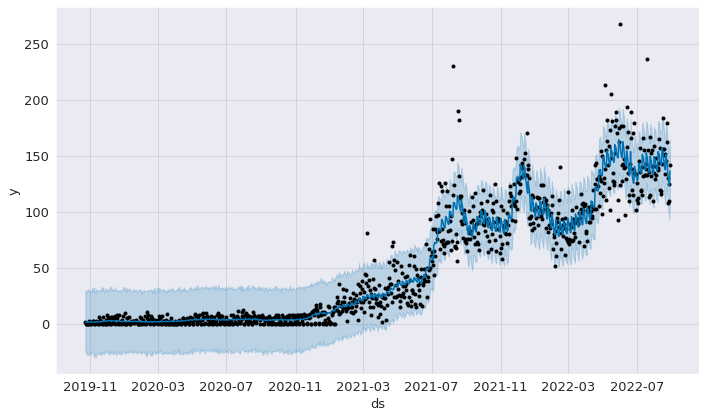

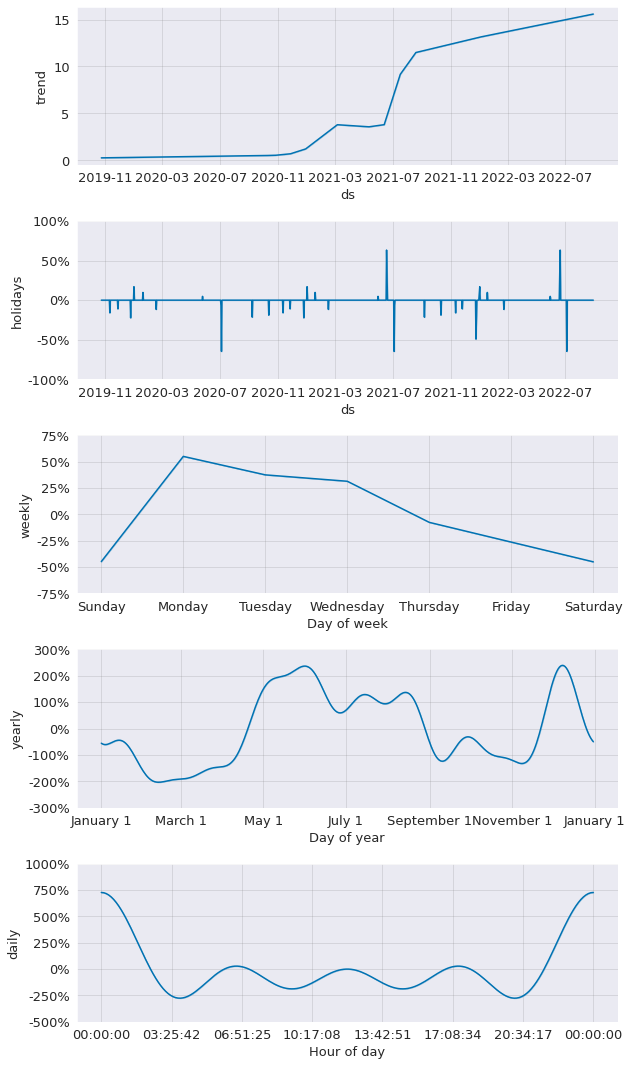

In [11]:
data = devs_vetted

anomalies = call_prophet(data)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(anomalies)

08:43:30 - cmdstanpy - INFO - Chain [1] start processing
08:43:30 - cmdstanpy - INFO - Chain [1] done processing
08:43:32 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
inf 69.99156798094329


08:43:32 - cmdstanpy - INFO - Chain [1] done processing
08:43:39 - cmdstanpy - INFO - Chain [1] start processing
08:43:39 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
69.99156798094329 69.38889873937106


08:43:41 - cmdstanpy - INFO - Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1] done processing
08:43:49 - cmdstanpy - INFO - Chain [1] start processing
08:43:49 - cmdstanpy - INFO - Chain [1] done processing
08:43:51 - cmdstanpy - INFO - Chain [1] start processing
08:43:51 - cmdstanpy - INFO - Chain [1] done processing
08:43:59 - cmdstanpy - INFO - Chain [1] start processing
08:43:59 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
69.38889873937106 69.1119829936621


08:44:01 - cmdstanpy - INFO - Chain [1] start processing
08:44:01 - cmdstanpy - INFO - Chain [1] done processing
08:44:09 - cmdstanpy - INFO - Chain [1] start processing
08:44:09 - cmdstanpy - INFO - Chain [1] done processing
08:44:11 - cmdstanpy - INFO - Chain [1] start processing
08:44:11 - cmdstanpy - INFO - Chain [1] done processing
08:44:19 - cmdstanpy - INFO - Chain [1] start processing
08:44:19 - cmdstanpy - INFO - Chain [1] done processing
08:44:21 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1] done processing
08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:44:29 - cmdstanpy - INFO - Chain [1] done processing
08:44:31 - cmdstanpy - INFO - Chain [1] start processing
08:44:31 - cmdstanpy - INFO - Chain [1] done processing
08:44:38 - cmdstanpy - INFO - Chain [1] start processing
08:44:39 - cmdstanpy - INFO - Chain [1] done processing
08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1]

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
69.1119829936621 54.396464876226396


08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
54.396464876226396 53.85916311335747


08:45:00 - cmdstanpy - INFO - Chain [1] start processing
08:45:00 - cmdstanpy - INFO - Chain [1] done processing
08:45:08 - cmdstanpy - INFO - Chain [1] start processing
08:45:08 - cmdstanpy - INFO - Chain [1] done processing
08:45:10 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
53.85916311335747 32.98292404592898


08:45:10 - cmdstanpy - INFO - Chain [1] done processing
08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
32.98292404592898 31.698183458144083


08:45:20 - cmdstanpy - INFO - Chain [1] start processing
08:45:20 - cmdstanpy - INFO - Chain [1] done processing
08:45:28 - cmdstanpy - INFO - Chain [1] start processing
08:45:28 - cmdstanpy - INFO - Chain [1] done processing
08:45:35 - cmdstanpy - INFO - Chain [1] start processing
08:45:35 - cmdstanpy - INFO - Chain [1] done processing
08:45:43 - cmdstanpy - INFO - Chain [1] start processing
08:45:43 - cmdstanpy - INFO - Chain [1] done processing
08:45:50 - cmdstanpy - INFO - Chain [1] start processing
08:45:50 - cmdstanpy - INFO - Chain [1] done processing
08:45:58 - cmdstanpy - INFO - Chain [1] start processing
08:45:58 - cmdstanpy - INFO - Chain [1] done processing
08:46:05 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
31.698183458144083 30.825868315595493


08:46:06 - cmdstanpy - INFO - Chain [1] done processing
08:46:13 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
30.825868315595493 30.316670627344013


08:46:14 - cmdstanpy - INFO - Chain [1] done processing
08:46:21 - cmdstanpy - INFO - Chain [1] start processing
08:46:21 - cmdstanpy - INFO - Chain [1] done processing
08:46:29 - cmdstanpy - INFO - Chain [1] start processing
08:46:29 - cmdstanpy - INFO - Chain [1] done processing
08:46:36 - cmdstanpy - INFO - Chain [1] start processing
08:46:36 - cmdstanpy - INFO - Chain [1] done processing
08:46:44 - cmdstanpy - INFO - Chain [1] start processing
08:46:44 - cmdstanpy - INFO - Chain [1] done processing
08:46:51 - cmdstanpy - INFO - Chain [1] start processing
08:46:51 - cmdstanpy - INFO - Chain [1] done processing
08:46:58 - cmdstanpy - INFO - Chain [1] start processing
08:46:58 - cmdstanpy - INFO - Chain [1] done processing
08:47:05 - cmdstanpy - INFO - Chain [1] start processing
08:47:05 - cmdstanpy - INFO - Chain [1] done processing
08:47:13 - cmdstanpy - INFO - Chain [1] start processing
08:47:13 - cmdstanpy - INFO - Chain [1] done processing
08:47:20 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
30.316670627344013 28.62831646606975


08:49:04 - cmdstanpy - INFO - Chain [1] done processing
08:49:11 - cmdstanpy - INFO - Chain [1] start processing
08:49:11 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
28.62831646606975 27.97003394763934


08:49:19 - cmdstanpy - INFO - Chain [1] start processing
08:49:19 - cmdstanpy - INFO - Chain [1] done processing
08:49:26 - cmdstanpy - INFO - Chain [1] start processing
08:49:26 - cmdstanpy - INFO - Chain [1] done processing
08:49:33 - cmdstanpy - INFO - Chain [1] start processing
08:49:33 - cmdstanpy - INFO - Chain [1] done processing
08:49:41 - cmdstanpy - INFO - Chain [1] start processing
08:49:41 - cmdstanpy - INFO - Chain [1] done processing
08:49:48 - cmdstanpy - INFO - Chain [1] start processing
08:49:48 - cmdstanpy - INFO - Chain [1] done processing
08:49:56 - cmdstanpy - INFO - Chain [1] start processing
08:49:56 - cmdstanpy - INFO - Chain [1] done processing
08:50:03 - cmdstanpy - INFO - Chain [1] start processing
08:50:03 - cmdstanpy - INFO - Chain [1] done processing
08:50:11 - cmdstanpy - INFO - Chain [1] start processing
08:50:11 - cmdstanpy - INFO - Chain [1] done processing
08:50:19 - cmdstanpy - INFO - Chain [1] start processing
08:50:19 - cmdstanpy - INFO - Chain [1]

Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95


08:50:26 - cmdstanpy - INFO - Chain [1] done processing


0    922
1     69
Name: anomaly, dtype: int64
The MAE for the model is 17.75412059884422
The MAPE for the model is 2250163862487582.5
The RMSE for the model is 27.97003394763934
            ds    y        mean        yhat  yhat_lower  yhat_upper  anomaly  \
172 2020-06-02   85   21.285714   20.106476  -34.089313   72.242592        1   
525 2021-05-21  124   59.142857   59.527168    3.220032  107.996607        1   
588 2021-07-23  171   94.285714   89.637086   32.587461  144.241955        1   
612 2021-08-16  178   94.428571  107.043606   52.687948  158.232351        1   
643 2021-09-16   57   67.000000  116.017229   61.794485  171.165497        1   
647 2021-09-20  186   77.285714  119.391100   66.454644  175.439320        1   
648 2021-09-21  234   94.428571  128.003015   72.115544  182.289406        1   
670 2021-10-13   71   79.000000  132.661699   79.244448  189.466611        1   
691 2021-11-03   81   94.428571  158.817282  103.793166  213.586736        1   
692 2021-11-04   82   

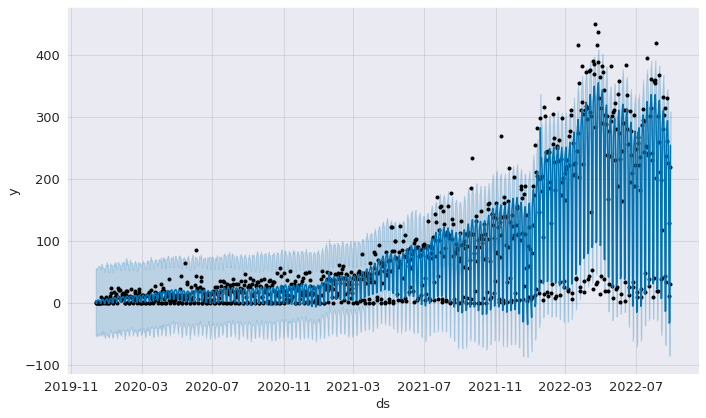

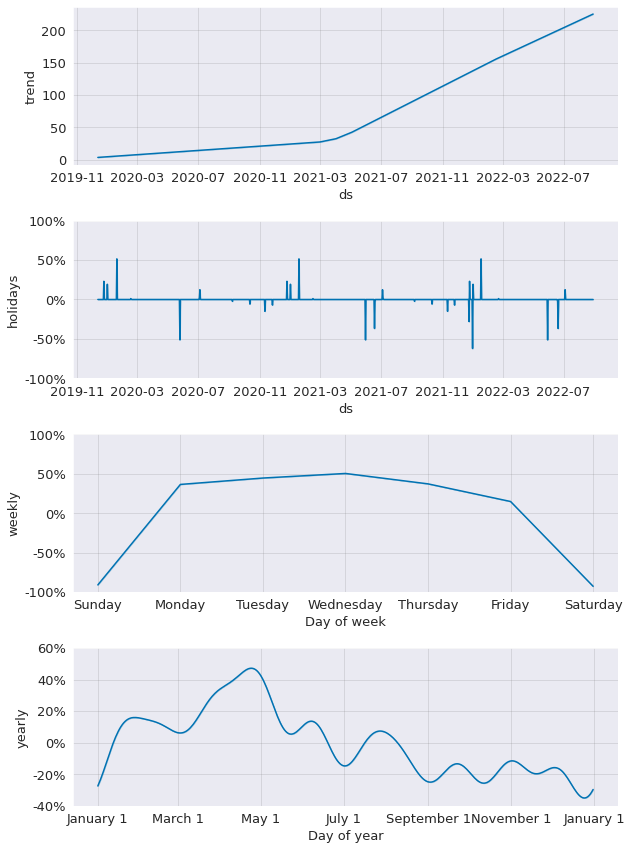

In [12]:
data = devs_shortlisted

anomalies = call_prophet(data)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(anomalies)

08:50:36 - cmdstanpy - INFO - Chain [1] start processing
08:50:36 - cmdstanpy - INFO - Chain [1] done processing
08:50:39 - cmdstanpy - INFO - Chain [1] start processing
08:50:39 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
inf 2.5574464224731717


08:50:47 - cmdstanpy - INFO - Chain [1] start processing
08:50:47 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
2.5574464224731717 2.5312421722801064


08:50:49 - cmdstanpy - INFO - Chain [1] start processing
08:50:49 - cmdstanpy - INFO - Chain [1] done processing
08:50:56 - cmdstanpy - INFO - Chain [1] start processing
08:50:56 - cmdstanpy - INFO - Chain [1] done processing
08:50:59 - cmdstanpy - INFO - Chain [1] start processing
08:50:59 - cmdstanpy - INFO - Chain [1] done processing
08:51:06 - cmdstanpy - INFO - Chain [1] start processing
08:51:06 - cmdstanpy - INFO - Chain [1] done processing
08:51:09 - cmdstanpy - INFO - Chain [1] start processing
08:51:09 - cmdstanpy - INFO - Chain [1] done processing
08:51:16 - cmdstanpy - INFO - Chain [1] start processing
08:51:16 - cmdstanpy - INFO - Chain [1] done processing
08:51:19 - cmdstanpy - INFO - Chain [1] start processing
08:51:19 - cmdstanpy - INFO - Chain [1] done processing
08:51:26 - cmdstanpy - INFO - Chain [1] start processing
08:51:26 - cmdstanpy - INFO - Chain [1] done processing
08:51:28 - cmdstanpy - INFO - Chain [1] start processing
08:51:28 - cmdstanpy - INFO - Chain [1]

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
2.5312421722801064 2.1554897764570904


08:51:58 - cmdstanpy - INFO - Chain [1] done processing
08:52:05 - cmdstanpy - INFO - Chain [1] start processing
08:52:06 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
2.1554897764570904 2.1274470558078313


08:52:08 - cmdstanpy - INFO - Chain [1] start processing
08:52:08 - cmdstanpy - INFO - Chain [1] done processing
08:52:16 - cmdstanpy - INFO - Chain [1] start processing
08:52:16 - cmdstanpy - INFO - Chain [1] done processing
08:52:18 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
2.1274470558078313 1.9154967027750962


08:52:18 - cmdstanpy - INFO - Chain [1] done processing
08:52:26 - cmdstanpy - INFO - Chain [1] start processing
08:52:26 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
1.9154967027750962 1.8854496193420134


08:52:28 - cmdstanpy - INFO - Chain [1] start processing
08:52:28 - cmdstanpy - INFO - Chain [1] done processing
08:52:36 - cmdstanpy - INFO - Chain [1] start processing
08:52:36 - cmdstanpy - INFO - Chain [1] done processing
08:52:43 - cmdstanpy - INFO - Chain [1] start processing
08:52:43 - cmdstanpy - INFO - Chain [1] done processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] done processing
08:52:58 - cmdstanpy - INFO - Chain [1] start processing
08:52:58 - cmdstanpy - INFO - Chain [1] done processing
08:53:05 - cmdstanpy - INFO - Chain [1] start processing
08:53:05 - cmdstanpy - INFO - Chain [1] done processing
08:53:13 - cmdstanpy - INFO - Chain [1] start processing
08:53:13 - cmdstanpy - INFO - Chain [1] done processing
08:53:21 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
1.8854496193420134 1.8849547931199278


08:53:21 - cmdstanpy - INFO - Chain [1] done processing
08:53:28 - cmdstanpy - INFO - Chain [1] start processing
08:53:28 - cmdstanpy - INFO - Chain [1] done processing
08:53:36 - cmdstanpy - INFO - Chain [1] start processing
08:53:36 - cmdstanpy - INFO - Chain [1] done processing
08:53:43 - cmdstanpy - INFO - Chain [1] start processing
08:53:43 - cmdstanpy - INFO - Chain [1] done processing
08:53:51 - cmdstanpy - INFO - Chain [1] start processing
08:53:51 - cmdstanpy - INFO - Chain [1] done processing
08:53:59 - cmdstanpy - INFO - Chain [1] start processing
08:53:59 - cmdstanpy - INFO - Chain [1] done processing
08:54:06 - cmdstanpy - INFO - Chain [1] start processing
08:54:06 - cmdstanpy - INFO - Chain [1] done processing
08:54:13 - cmdstanpy - INFO - Chain [1] start processing
08:54:13 - cmdstanpy - INFO - Chain [1] done processing
08:54:21 - cmdstanpy - INFO - Chain [1] start processing
08:54:21 - cmdstanpy - INFO - Chain [1] done processing
08:54:28 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
1.8849547931199278 1.8629343851650084


08:56:15 - cmdstanpy - INFO - Chain [1] done processing
08:56:22 - cmdstanpy - INFO - Chain [1] start processing
08:56:23 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
1.8629343851650084 1.8395368351940289


08:56:30 - cmdstanpy - INFO - Chain [1] start processing
08:56:30 - cmdstanpy - INFO - Chain [1] done processing
08:56:37 - cmdstanpy - INFO - Chain [1] start processing
08:56:38 - cmdstanpy - INFO - Chain [1] done processing
08:56:45 - cmdstanpy - INFO - Chain [1] start processing
08:56:45 - cmdstanpy - INFO - Chain [1] done processing
08:56:53 - cmdstanpy - INFO - Chain [1] start processing
08:56:53 - cmdstanpy - INFO - Chain [1] done processing
08:57:01 - cmdstanpy - INFO - Chain [1] start processing
08:57:01 - cmdstanpy - INFO - Chain [1] done processing
08:57:08 - cmdstanpy - INFO - Chain [1] start processing
08:57:08 - cmdstanpy - INFO - Chain [1] done processing
08:57:16 - cmdstanpy - INFO - Chain [1] start processing
08:57:16 - cmdstanpy - INFO - Chain [1] done processing
08:57:23 - cmdstanpy - INFO - Chain [1] start processing
08:57:24 - cmdstanpy - INFO - Chain [1] done processing
08:57:31 - cmdstanpy - INFO - Chain [1] start processing
08:57:31 - cmdstanpy - INFO - Chain [1]

Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95


08:57:39 - cmdstanpy - INFO - Chain [1] done processing


0    968
1     73
Name: anomaly, dtype: int64
The MAE for the model is 1.2256550780531665
The MAPE for the model is 1124105691191086.2
The RMSE for the model is 1.8395368351940289
             ds   y      mean      yhat  yhat_lower  yhat_upper  anomaly  \
204  2020-05-15   6  1.857143  1.007619   -2.750887    4.406325        1   
231  2020-06-11   5  1.000000  1.206768   -2.392641    4.985314        1   
264  2020-07-14   5  1.571429  1.277797   -2.450471    4.883159        1   
321  2020-09-09   9  2.285714  1.335091   -2.208220    5.177869        1   
335  2020-09-23   5  2.142857  1.490675   -2.076388    4.950051        1   
601  2021-06-16   8  3.000000  3.260332   -0.253447    6.858425        1   
602  2021-06-17  10  3.571429  3.350071    0.272394    6.957270        1   
603  2021-06-18   9  4.428571  4.415893    0.913341    8.291238        1   
606  2021-06-21  10  5.571429  3.140816   -0.212301    6.713701        1   
613  2021-06-28   8  2.857143  2.874739   -0.800536    6.354

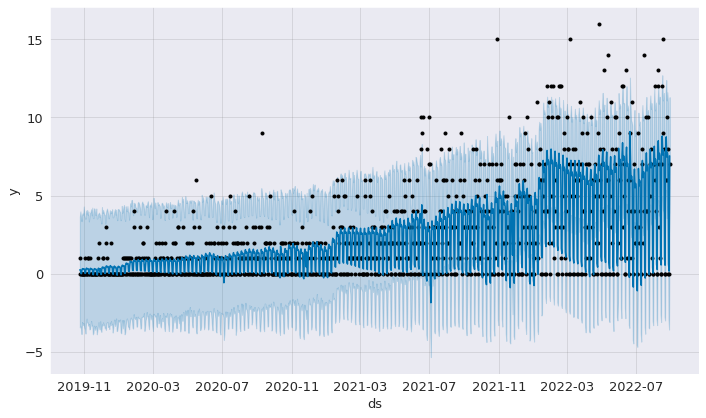

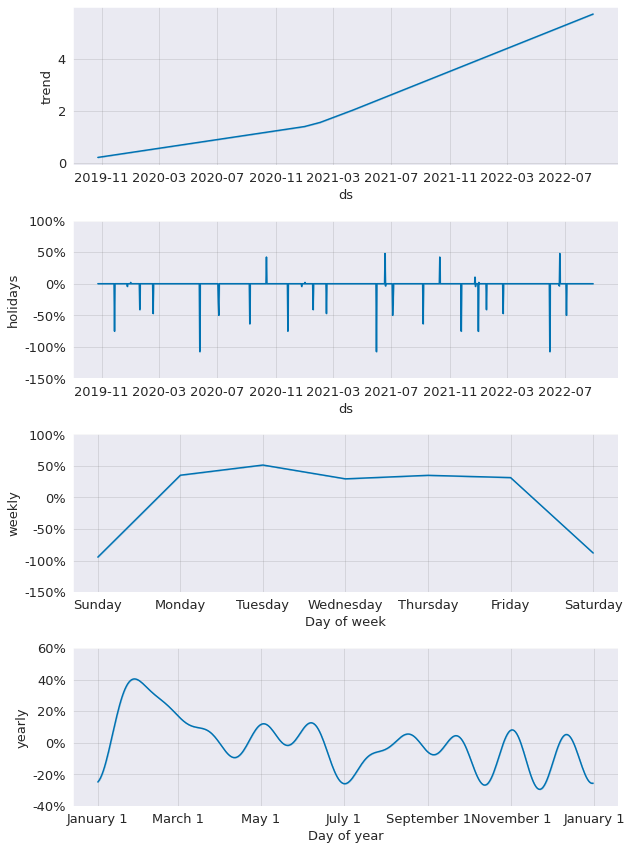

In [13]:
data = devs_chosen

anomalies = call_prophet(data)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(anomalies)